# Introduction
<center> <h1> Image Classification using Deep Learning models </h1> </center>

<p>Dans ce notebook nous allons utiliser plusieurs modèles de Deep Learning pour resoudre un problème de classification d'images. (https://challengedata.ens.fr/challenges/59)<p>


As part of a Challenge provided by the Institute of Technology **Rakuten** (*https://challengedata.ens.fr/challenges/35*), the present work aims at developing two efficient **Deep Learning** models for the large-scale product classification into product type codes. For this challenge **Rakuten** has provided a datasets containing roughly 85k labeled products (the train set) and 14k non labeled ones (the test set). The datasets contain the following features: 

- **designation** containing the product title and a short text about the product
- **description** including a more detailed description of the product
- **productid** that is a unique ID for each product
- **imageid** that is a unique ID for the image associated with the product

Different network models have been tested in order to find the most accurate one for this particular task and the two best models have been reported together with an in-depth performance analysis carried out by means of the accuracy, recall, precision and f1 metrics.
The resulting models have been trained by using the image dataset.

The present report consists of 5 sections organized as follows:
1. Setting up of Google Colaboratory
2. Functions definition
3. Configuration of the general parameters used by the different models
4. Datasets set-up
5. DeepLearning models for the image part.



# 0.Import of libraries




In [4]:
# ---------------------------------------------------------------------------
# Import of libraries
# ---------------------------------------------------------------------------

import numpy as np
import pandas as pd

import sys
import os
import time
import datetime
from timeit import default_timer as timer
from packaging import version
import itertools  
import glob

# libraries sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report,  accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils import class_weight

# libraries Matplotlib and figures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image, ImageChops #
from tqdm import tqdm
import joblib #
from IPython.core.pylabtools import figsize #

# Librairies tensorflow
import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet, VGG16, xception
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

# Load the TensorBoard notebook extension.
%load_ext tensorboard
import tensorboard

# Google Colab
from google.colab import drive
%tensorflow_version 2.x

print("Modules importation successful")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Modules importation successful


#1.Setting up of Google Colaboratory

Preparation of the data environment (path and copy)

In [2]:
# CHECK of the GPU connection.

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 13 18:15:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# CHECK PYTHON VERSION
print(f"\n>> Python version:\n {sys.version}")

# CHECK TENSORFLOW VERSION
print(f"\n>> TensorFlow version:\n {tf.version.VERSION}")

# CHECK TENSORBOARD VERSION
print(f"\n>> TensorBoard version:\n {tensorboard.__version__}")

# Check is Link to Drive is OK
print("\n>> Google Drive:")
drive.mount('/content/drive/')
!if [ -d '/content/drive' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi



>> Python version:
 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]

>> TensorFlow version:
 2.8.0

>> TensorBoard version:
 2.8.0

>> Google Drive:
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Connection to Google drive successful


Data is unzipped to local Colab disks for faster execution of the code.

In [7]:
# Switch to bash (cell-wise)
%%bash

# Images source and destination
SRC1="/content/drive/MyDrive/eBimPy/images/image_train.zip"
SRC2="/content/drive/MyDrive/eBimPy/images/image_test.zip"
DEST="/tmp/eBimPy"

#rm -r $DEST
# Check it has not been done
if [ -d "$DEST" ]; then
    echo "Images already unzipped"
else
    # Create directory
    mkdir -p "$DEST"
    # Unzip images
    unzip -q "$SRC1" -d "$DEST"
    unzip -q "$SRC2" -d "$DEST"
    echo "Images unzipped"
fi


Images unzipped


warning [/content/drive/MyDrive/eBimPy/images/image_train.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/eBimPy/images/image_train.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #84918).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


#2 .Functions definition



In [8]:
# Removing image borders to keep only useful content 
def supprimer_cadre(im):
    
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

# 3.Configuration of the general parameters used by the different models
<p>This frame introduces the different constants and related hyper parameters.<p>
**The paths to the datasets should be individually adapted.**

In [9]:
# Paths to datasets and backups.
inRep = r"/content/drive/MyDrive/eBimPy/"
outRep = r"/content/drive/MyDrive/eBimPy/out/"
train_path = "/tmp/eBimPy/image_train/"
test_path = "/content/image_test/image_"
checkpoint_dir = "/tmp/classification/models/"
model_savepath    = r"/content/drive/MyDrive/eBimPy/saved_models/"

# Image size in pixels when reduced.
width = 224
height = 224

# General settings of the models
TEST_SIZE = 0.20
EPOCH      = 10     # number of epoch 
BATCH_SIZE = 22     # batch processing of images before gradient descent (multiple of 16 984)
CLASS_MODE = "categorical"


# Parameters specific to the VGG16 model
IMGSIZE       = 224    # Input image size
FREEZE_LAYERS = 15     # For a VGG16 freeze relearning some layers
TRAIN         = None   # Training or using an already trained network

# 4.Datasets set-up
<p>Loading data, calculating labels, adding paths....<p>

##4.1.Loading of the descriptive file of train images and of the file containing their labels.
The whole is concatenated in a dataframe named df.

In [10]:
# Training dataframe provided for the challenge.
df_image = pd.read_csv(inRep+'X_train_update.csv', index_col = 0)
df_label = pd.read_csv(inRep+'Y_train_CVw08PX.csv', index_col = 0)

df = pd.concat([df_image, df_label], axis = 1)

# Display of a few lines of the df containing images and labels
display(df.head(5))

,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705


Let’s look at the imbalance between categories:

percentage of products per category (%): 


,counts %
prdtypecode,
2583,12.02
1560,5.97
1300,5.94
2060,5.88
2522,5.88
1280,5.74
2403,5.62
2280,5.61
1920,5.07


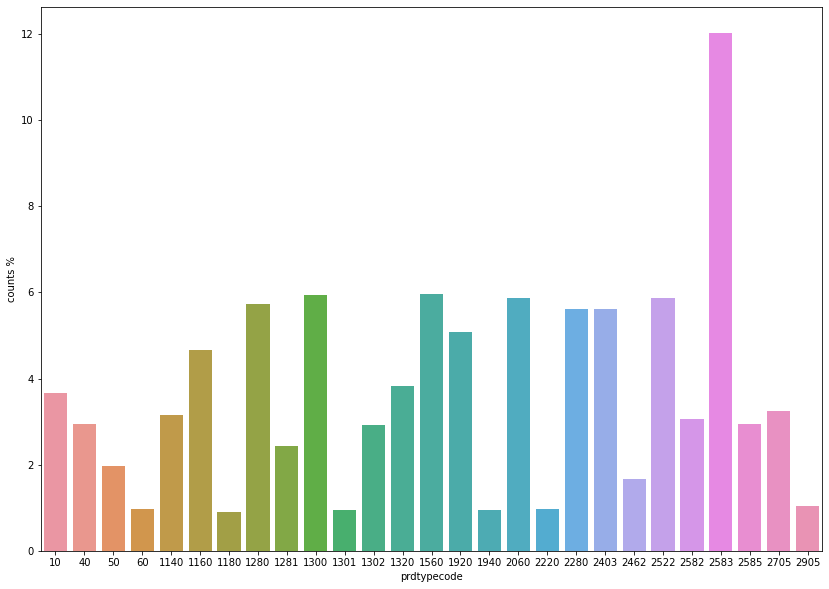

In [ ]:
plt.figure(figsize=(14,10))
print("percentage of products per category (%): ")
df_vis2=round(df["prdtypecode"].value_counts(normalize=True)*100,2).rename_axis("prdtypecode").to_frame("counts %")
sns.barplot(data=df_vis2.reset_index(),x="prdtypecode",y="counts %")
display(df_vis2);

The dataset is not very balanced at the category level. We will take care of it later when creating our train and validation datasets with class_weights.

##4.2 Creation of dictionaries

###a) Imageid, productid

In [11]:
# The image is defined by the couple ('imageid', 'productid')
dico_img_id_label = dict(zip(zip(df['imageid'], df['productid']), df['prdtypecode']))

###b) Prdtypecode, name_category
A dictionary which associates the prdtypecode to the associated category name has been definide based on a word cloud analysis (cf. the Text part).

In [12]:
dic= {10:"school books, guides, biographies",2280:"magazines, newspapers, press",50:"video game console accessories",1280:"plush, figurine, children's games",
      2705: "human sciences and philosophy", 2522: "stationery", 2582: "garden furniture", 1560: "interior decoration",
      1281:"board games for children",1920:"bedroom accessories",2403:"series, comics and collections",1140:"anime and starwars articles",
      2583:"swimming pool",1180:"fantasy and horror",1300:"drones",2462:"consoles and video games",1160:"cards and figurines",2060:"accessories and decorations for the home",
      40:"vintage games",60:"vintage consoles",1320:"accessories for babies",1302:"games and accessories for children",2220:"accessories for animals",2905:"pc video games",
      2585:"garden tools",1940:"snack",1301:"playroom and children's shoes"}

##4.3 Display of some images.

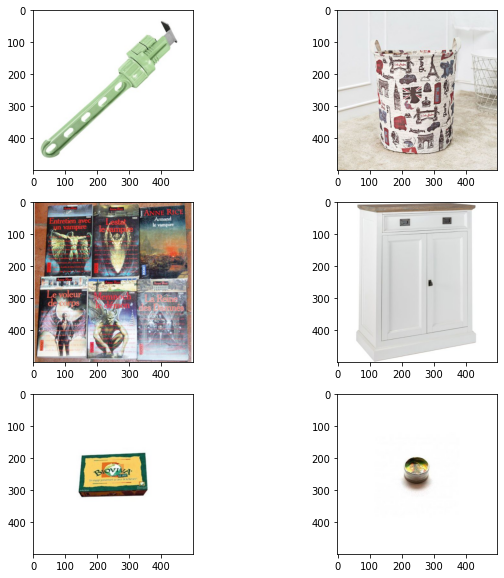

In [13]:
plt.figure(figsize = (10, 10))

number_of_images = 6 

i = 0
files = glob.glob(train_path + '*.jpg')

for name in files[:number_of_images]:
  try :
    #print(name)
    file = mpimg.imread(name)
    plt.subplot(number_of_images//2,2,i+1)
    plt.imshow(file)
    i +=1
  except:
    continue


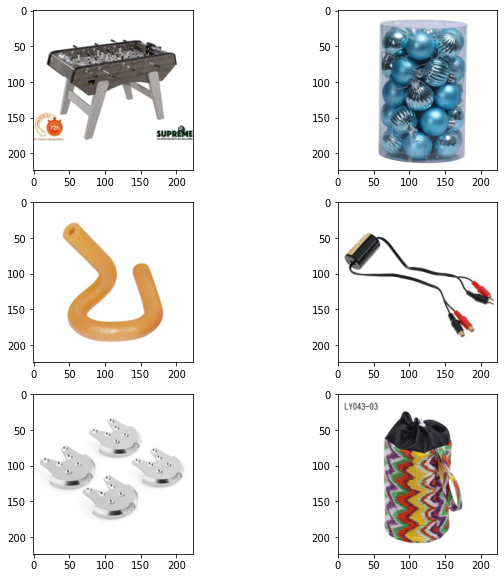

In [ ]:
# Display of the same images after resizing. 
plt.figure(figsize = (10, 10))

number_of_images = 6

i = 0
files = glob.glob(train_path + '*.jpg')
for name in files[:number_of_images]:
  try:
    im = Image.open(name)
    im = im.convert('RGB')
    #im = supprimer_cadre(im)
    im = im.resize((width, height))
    
    plt.subplot(number_of_images//2,2,i+1)
    plt.imshow(im)
    i += 1
  except :
    continue


##4.4 Loading the path of train images.
With verification and integration in the dataframe of a new 'path' column.

In [15]:
images_path = {}
files = glob.glob(train_path + '/*.jpg')

for f in files:
    try:
        name = os.path.basename(f)
        imageid = int(name.split('_')[1])
        productid = int(name.split('_')[-1].split('.')[0])
        images_path[(imageid,productid)] = f
        
    except :
        print(f)
        

print("Number of valid image names taken in the train: ", len(images_path))
print("Number of invalid image names not taken on the train : ", len(df_image) - len(images_path))


Number of valid image names taken in the train:  84916
Number of invalid image names not taken on the train :  0


In [16]:
# Applying the dictionary to df_image
df['path'] = df.set_index(['imageid', 'productid']).index.map(images_path)

#Do not forget to define the df variables as string for the rest.
df = df.astype('str')

# Display of the dataframe with the image paths variable
display(df.head())


,designation,description,productid,imageid,prdtypecode,path
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,nan,3804725264,1263597046,10,/tmp/eBimPy/image_train/image_1263597046_produ...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,nan,436067568,1008141237,2280,/tmp/eBimPy/image_train/image_1008141237_produ...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,/tmp/eBimPy/image_train/image_938777978_produc...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,nan,50418756,457047496,1280,/tmp/eBimPy/image_train/image_457047496_produc...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,/tmp/eBimPy/image_train/image_1077757786_produ...


##4.5 Data preparation : training and validation.

Methodology: using images in train_images for training and evaluating each model.
  - 80% of the images will be used for training.
  - 20% of the remaining images will be used to evaluate each model on data, validation part.
We split our df in two thanks to train_test_split. We stratify this split on the target variable, here 'prdtypecode'.


<p>
Then we use ImageDataGenerator and flow_from_dataframe to link the df and the image file.
The following tutorial was followed for further explanation: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
<p>

In [17]:
df_train, df_validation = train_test_split(df, test_size=TEST_SIZE, stratify=df['prdtypecode'], random_state=42)

In [18]:
datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input,
                                                        # data augmentation
                                                        rotation_range = 20,
                                                      width_shift_range = 0.1,
                                                        height_shift_range = 0.1,
                                                       horizontal_flip = True,
                                                       brightness_range=[0.2,1.5]
                                                        )

#Il faut que l'on discute du preprocess_input, je ne l'ai pas mis pour le moment.

train_datagen=datagen_train.flow_from_dataframe(
  dataframe=df_train,
  x_col="path",
  y_col="prdtypecode",
  batch_size=BATCH_SIZE,
  seed=None,
  shuffle=True,
  class_mode=CLASS_MODE,
  color_mode= "rgb",
  target_size=(width, height))


datagen_validator=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input)

validator_datagen=datagen_validator.flow_from_dataframe(
  dataframe=df_validation,
  x_col="path",
  y_col="prdtypecode",
  batch_size=BATCH_SIZE,
  seed=None,
  shuffle=False,
  class_mode=CLASS_MODE,
  color_mode= "rgb",
  target_size=(width, height))


# Generation of STEPS_SIZE

STEP_SIZE_TRAIN = train_datagen.n // train_datagen.batch_size
STEP_SIZE_VALID = validator_datagen.n // validator_datagen.batch_size

print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)


Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.
3087 772


As seen previously, the categories are not present in a balanced way. We create a dictionary of weights (class_weights) in order to integrate it during the training of our model. The less represented classes will have a greater penality weight.

In [19]:
class_weights = class_weight.compute_class_weight(
              class_weight='balanced',
              classes= np.unique(train_datagen.classes), 
              y=train_datagen.classes) 

class_weights = {i : class_weights[i] for i in range(27)}

class_weights

{0: 1.0092258323305254,
 1: 1.1773514272344408,
 2: 0.7956989247311828,
 3: 4.11783960720131,
 4: 0.6457905544147844,
 5: 1.5193236714975846,
 6: 0.6233894945490585,
 7: 3.8947368421052633,
 8: 1.2624184646261916,
 9: 0.9703046664095643,
 10: 0.6200098570724495,
 11: 0.7309703660662406,
 12: 3.9190031152647977,
 13: 0.6299449173760641,
 14: 3.8179059180576633,
 15: 0.6607142857142857,
 16: 0.6588112071222834,
 17: 2.212840809146878,
 18: 0.63041844149336,
 19: 1.21487204249155,
 20: 0.30806905840577936,
 21: 1.2598898347521281,
 22: 1.1389769126301494,
 23: 3.6045845272206303,
 24: 1.2542372881355932,
 25: 1.870631970260223,
 26: 3.7777777777777777}

In [24]:
CALLBACKS = [
    ModelCheckpoint(model_savepath+'vgg_ai4_FT2',verbose=1)
    ]

#5 DeepLearning models for the image part.
Here are our two best models over all. Unfortunately the training figures on 10 epochs have been lost for the 2 models.

##4.2 Classification based on a CNN (LeNet) without image augmentation.

###a) Loading the model

In [34]:
model = keras.models.load_model(model_savepath+'lenet_256')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 252, 252, 30)      2280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 30)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 16)      4336      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 61504)             0         
                                                                 
 dropout_3 (Dropout)         (None, 61504)            

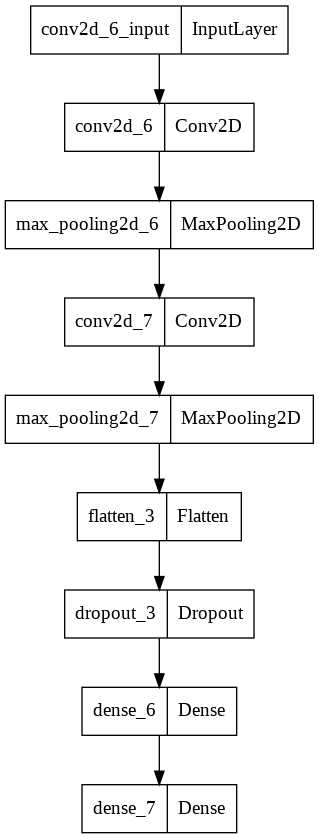

In [35]:
# Affichage de l'architecture du modèle
print(model.summary())
plot_model(model)

###b) Model evaluation

We test our model on the test_datagen part that we created earlier on our initial dataset.

In [36]:
# We get the true prdtypecode value
true_prdtypecode = df_validation.prdtypecode.values

validator_datagen.reset()
# Probabilities returned by the model
pred=model.predict(validator_datagen,
                                steps=STEP_SIZE_VALID,
                                verbose=1)

# Prdtypecode category index prediction
pred_prdtypecode_indices=np.argmax(pred,axis=1)

# prdtypecode prediction
labels = (validator_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_prdtypecode = np.array([labels[k] for k in pred_prdtypecode_indices])

true_prdtypecode=true_prdtypecode.astype(str)
pred_prdtypecode=pred_prdtypecode.astype(str)

772/772 [==============================] - 112s 144ms/step


In [40]:
acc = accuracy_score(true_prdtypecode, pred_prdtypecode)
print("Model accuracy : {:.2f}%".format(acc * 100))

Model accuracy : 41.81%


Perfomance du modèle

In [38]:
print(classification_report(true_prdtypecode, pred_prdtypecode))

              precision    recall  f1-score   support

          10       0.44      0.37      0.40       623
        1140       0.30      0.27      0.28       534
        1160       0.79      0.75      0.77       791
        1180       0.18      0.14      0.15       153
        1280       0.20      0.21      0.20       974
        1281       0.09      0.11      0.10       414
        1300       0.36      0.49      0.41      1009
        1301       0.43      0.17      0.25       161
        1302       0.16      0.22      0.19       498
        1320       0.24      0.21      0.22       648
        1560       0.36      0.30      0.33      1015
        1920       0.64      0.58      0.61       861
        1940       0.18      0.22      0.20       161
        2060       0.27      0.27      0.27       999
        2220       0.21      0.12      0.15       165
        2280       0.59      0.57      0.58       952
        2403       0.40      0.45      0.42       955
        2462       0.22    

Matrice de confusion

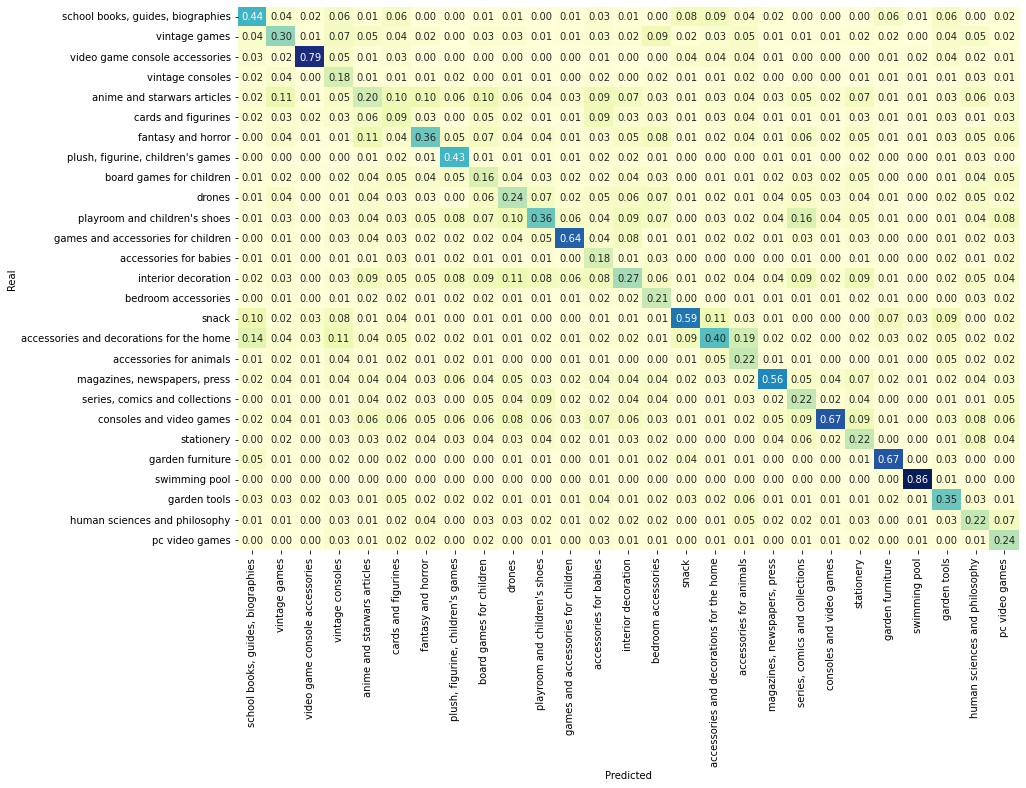

In [39]:
conf_matrix = pd.crosstab(true_prdtypecode,pred_prdtypecode,rownames=["Real"],colnames=["Predicted"],normalize="columns")
plt.figure(figsize=(14,10))
import seaborn as sns
tick_labels = [j for k,j in sorted(dic.items())]
ax = plt.subplot()
sns.heatmap(conf_matrix, fmt='.2f',annot=True,cmap="YlGnBu", cbar=False,ax=ax)
ax.xaxis.set_ticklabels(tick_labels,rotation=90,fontsize=10);
ax.yaxis.set_ticklabels(tick_labels, rotation=0,fontsize=10);

Here is our best results with a model based on CNN. LeNet is a CNN network designed by Yann Lecun (https://en.wikipedia.org/wiki/LeNet). Image augmentation did not improve the model. In the next part, we will use a pre-trained model for image classification called VGG16.

##5.2 Classification based on VGG16 with image augmentation.

###a) Loading the model

In [25]:
model = keras.models.load_model(model_savepath+'vgg_ai4')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_9 (Dropout)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_17 (Dense)            (None, 4096)              16781312  
                                                                 
 batch_normalization_4 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                     

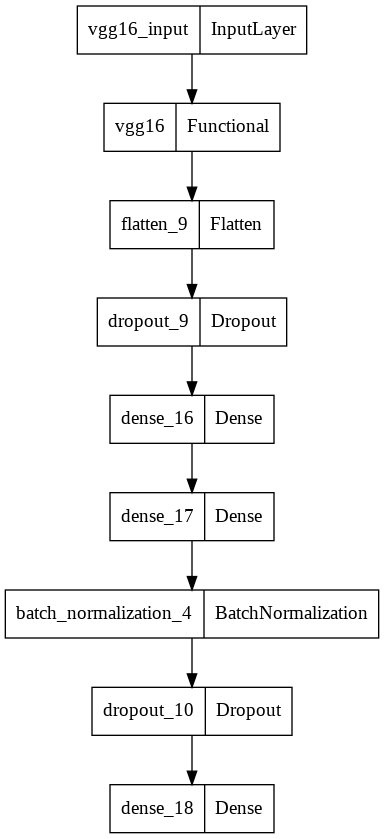

In [26]:
# Display of the architecture of the model
print(model.summary())
plot_model(model)

###b) Model evaluation

We test our model on the test_datagen part that we created earlier on our initial dataset.

In [27]:
# We get the true prdtypecode value
true_prdtypecode = df_validation.prdtypecode.values

validator_datagen.reset()
# Probabilities returned by the model
pred=model.predict(validator_datagen,
                                steps=STEP_SIZE_VALID,
                                verbose=1)

# Prdtypecode category index prediction
pred_prdtypecode_indices=np.argmax(pred,axis=1)

# prdtypecode prediction
labels = (validator_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_prdtypecode = np.array([labels[k] for k in pred_prdtypecode_indices])

true_prdtypecode=true_prdtypecode.astype(str)
pred_prdtypecode=pred_prdtypecode.astype(str)

772/772 [==============================] - 168s 203ms/step


In [28]:
acc = accuracy_score(true_prdtypecode, pred_prdtypecode)
print("Model accuracy : {:.2f}%".format(acc * 100))

Accuracy du modèle : 62.86%


Model performance

In [29]:
print(classification_report(true_prdtypecode, pred_prdtypecode))

              precision    recall  f1-score   support

          10       0.55      0.52      0.53       623
        1140       0.61      0.64      0.62       534
        1160       0.76      0.95      0.85       791
        1180       0.58      0.34      0.43       153
        1280       0.46      0.37      0.41       974
        1281       0.31      0.34      0.32       414
        1300       0.68      0.74      0.71      1009
        1301       0.64      0.65      0.64       161
        1302       0.45      0.54      0.49       498
        1320       0.49      0.48      0.48       648
        1560       0.64      0.56      0.60      1015
        1920       0.76      0.84      0.80       861
        1940       0.68      0.71      0.70       161
        2060       0.53      0.48      0.50       999
        2220       0.45      0.36      0.40       165
        2280       0.65      0.77      0.71       952
        2403       0.72      0.54      0.62       955
        2462       0.49    

Confusion Matrix

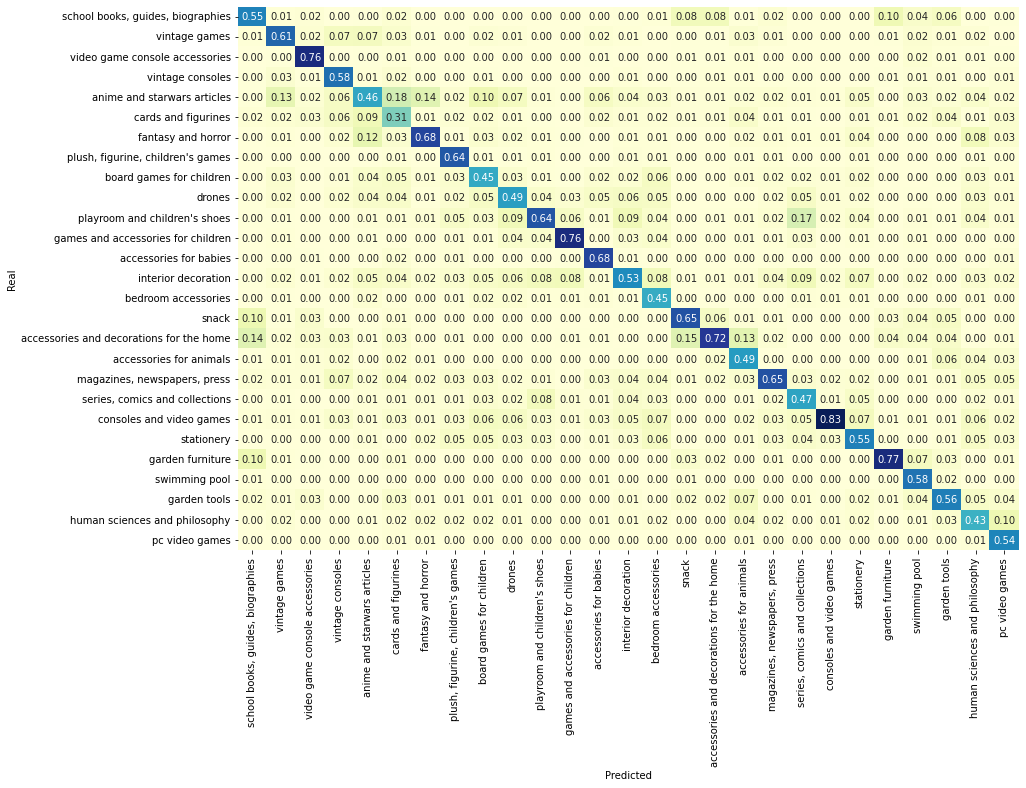

In [30]:
conf_matrix = pd.crosstab(true_prdtypecode,pred_prdtypecode,rownames=["Real"],colnames=["Predicted"],normalize="columns")
plt.figure(figsize=(14,10))
import seaborn as sns
tick_labels = [j for k,j in sorted(dic.items())]
ax = plt.subplot()
sns.heatmap(conf_matrix, fmt='.2f',annot=True,cmap="YlGnBu", cbar=False,ax=ax)
ax.xaxis.set_ticklabels(tick_labels,rotation=90,fontsize=10);
ax.yaxis.set_ticklabels(tick_labels, rotation=0,fontsize=10);

Here is are best model over all for images classification. Augmented images did show some improvement versus none. All the catagories are better than the previous CNN no pre-trained model. 

We have categories for items that are quiet similar: books, magazines, textbooks. The model has trouble classifying those items.